In [12]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import cv2
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
def preprocess_image(image, target_size):
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406])     # Channel-wise normalization (ImageNet statistics)
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std

    image = np.transpose(image, (2, 0, 1))     # Convert HWC → CHW format
    return image

In [4]:
dataset_dir = 'Datasets/OPTIMAL-31_MCC'
target_size = (256, 256)

class_labels = sorted(os.listdir(dataset_dir))
label_map = {cls_name: idx for idx, cls_name in enumerate(class_labels)}

images = []
labels = []

for class_name in class_labels:
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_image(image, target_size)

        images.append(image)
        label_vector = np.eye(len(class_labels), dtype=np.float32)[label_map[class_name]]
        labels.append(label_vector)

# Convert lists to NumPy arrays
all_images = np.array(images, dtype=np.float32)
all_labels = np.array(labels, dtype=np.float32)

In [5]:
labeled_ratio = 0.25
test_ratio = 0.2

In [14]:
num_samples = all_images.shape[0]
num_classes = all_labels.shape[1]

# Split into train, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=test_ratio, random_state=42,
    stratify=np.argmax(all_labels, axis=1)
)

# Further split training data into labeled and unlabeled
labeled_images, unlabeled_images, labeled_images_labels, _ = train_test_split(
    train_images, train_labels, train_size=labeled_ratio, random_state=42,
    stratify=np.argmax(train_labels, axis=1)
)

In [15]:
print(f"Training: {len(train_images)}, Testing: {len(test_images)}")
print(f"Labeled: {len(labeled_images)}, Unlabeled: {len(unlabeled_images)}")

Training: 1488, Testing: 372
Labeled: 372, Unlabeled: 1116


In [16]:
def extract_features(images, feature_extractor, batch_size=128):
    feature_extractor.eval() # Disables dropout and batch normalization updates
    feature_extractor = feature_extractor.to(device)

    # Convert images to PyTorch tensors
    image_tensors = torch.FloatTensor(images)
    dataset = TensorDataset(image_tensors)
    dataloader = DataLoader(dataset, batch_size, shuffle=False)

    features = []
    with torch.no_grad():  # Disable gradient computation to save memory
        for batch in dataloader:
            batch_images = batch[0].to(device)
            batch_features = feature_extractor(batch_images)

            # Handle both 4D and 2D feature tensors
            if batch_features.dim() == 4:  # 4D tensor (batch_size, feature_dim, 1, 1)
                # Flatten the feature tensor from (batch_size, feature_dim, 1, 1) to (batch_size, feature_dim)
                batch_features = batch_features.view(batch_features.size(0), -1)
            elif batch_features.dim() == 2:  # 2D tensor (batch_size, feature_dim)
                pass  # No need to reshape

            # Move features to CPU and convert to NumPy array
            features.append(batch_features.cpu().numpy())
    return np.vstack(features)  # Combine all batches into a single NumPy array

In [17]:
model_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, num_classes)

# model_efficientnet_b2 = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
# model_efficientnet_b2.classifier[1] = nn.Linear(model_efficientnet_b2.classifier[1].in_features, num_classes)

In [20]:
# model = model_efficientnet_b2.to(device)
model=model_resnet50.to(device)

if labeled_images_labels.ndim == 2:
    labeled_images_labels = np.argmax(labeled_images_labels, axis=1)

train_dataset = TensorDataset(
    torch.tensor(labeled_images).float(),
    torch.tensor(labeled_images_labels).long()  # Change to long for CrossEntropyLoss
)
    
print(f"Image tensor shape: {train_dataset.tensors[0].shape}") # Shape: [N, 3, H, W]

Image tensor shape: torch.Size([372, 3, 256, 256])


Epoch 1/20 loss: 3.0490
Epoch 2/20 loss: 1.6443
Epoch 3/20 loss: 0.7873
Epoch 4/20 loss: 0.3251
Epoch 5/20 loss: 0.1351
Epoch 6/20 loss: 0.0718
Epoch 7/20 loss: 0.0456
Epoch 8/20 loss: 0.0374
Epoch 9/20 loss: 0.0229
Epoch 10/20 loss: 0.0230
Epoch 11/20 loss: 0.0171
Epoch 12/20 loss: 0.0211
Epoch 13/20 loss: 0.0457
Epoch 14/20 loss: 0.0198
Epoch 15/20 loss: 0.0359
Epoch 16/20 loss: 0.0646
Epoch 17/20 loss: 0.0471
Epoch 18/20 loss: 0.0521
Epoch 19/20 loss: 0.0453
Epoch 20/20 loss: 0.0298


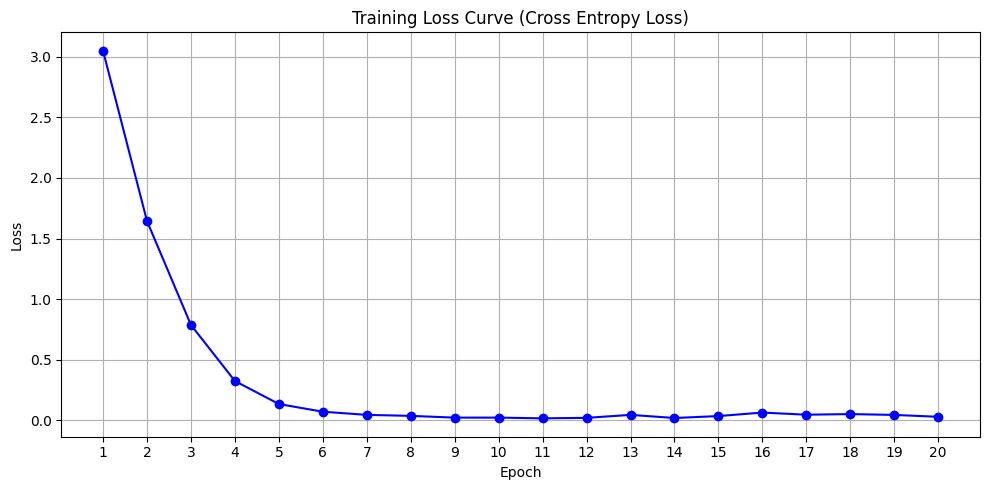

In [22]:
losses = []

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()  # Changed from BCEWithLogitsLoss to CrossEntropyLoss
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

epochs=20

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # CrossEntropyLoss expects class indices, not one-hot
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs} loss: {epoch_loss:.4f}")

feature_extractor = nn.Sequential(*list(model.children())[:-1])
feature_extractor=feature_extractor.to(device)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Curve (Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, epochs+1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
labeled_images_features = extract_features(labeled_images, feature_extractor)
unlabeled_images_features = extract_features(unlabeled_images, feature_extractor)
test_images_features = extract_features(test_images, feature_extractor)

print(f"Labeled features shape: {labeled_images_features.shape}")
print(f"Unlabeled features shape: {unlabeled_images_features.shape}")
print(f"Test features shape: {test_images_features.shape}")

Labeled features shape: (372, 2048)
Unlabeled features shape: (1116, 2048)
Test features shape: (372, 2048)


In [24]:
def calculate_variance(node_features, node_labels, w):
    # Label Variance (only labeled data; ignore unlabeled with nan)
    label_var = 0.0
    labeled_mask = ~np.isnan(node_labels)  # Mask for labeled examples
    if np.sum(labeled_mask) > 0:
        # For multi-class classification, use entropy of class distribution
        classes, counts = np.unique(node_labels[labeled_mask], return_counts=True)
        probs = counts / counts.sum()
        # Gini impurity for classification
        label_var = 1 - np.sum(probs ** 2)
    else:
        label_var = 0  # No labeled data in this node

    # Feature Variance (use all data)
    feature_var = np.var(node_features, axis=0, ddof=0).mean()
    return w * label_var + (1 - w) * feature_var

In [25]:
def build_pct(X, y, depth=0, max_depth=5, min_samples_split=2, w=1, parent_prototype=None):
    # Create a variable to store prototype for this node
    node_prototype = None
    
    # Compute prototype using ONLY LABELED DATA
    labeled_mask = ~np.isnan(y)
    if np.sum(labeled_mask) > 0:
        # For MCC, prototype is the most frequent class
        classes, counts = np.unique(y[labeled_mask], return_counts=True)
        node_prototype = classes[np.argmax(counts)]
    elif parent_prototype is not None:
        # If no labeled data but parent has prototype, inherit from parent
        node_prototype = parent_prototype
    else:
        # If no labeled data and no parent prototype, use -1 to indicate unknown
        node_prototype = -1
    
    if depth >= max_depth or len(y) < min_samples_split:
        return {'type': 'leaf', 'prediction': node_prototype}

    best_split = None
    best_score = float('inf')
    best_split_idx = None

    n_features = X.shape[1]
    feature_subset_size = max(1, int(np.sqrt(n_features)))
    feature_indices = np.random.choice(n_features, feature_subset_size, replace=False)
    
    for feature_idx in feature_indices:
        feature_values = X[:, feature_idx]
        
        if len(np.unique(feature_values)) > 10:
            percentiles = np.percentile(feature_values, [25, 50, 75])
            split_candidates = percentiles
        else:
            split_candidates = np.unique(feature_values)
        
        for split_val in split_candidates:
            left_mask = feature_values <= split_val
            right_mask = ~left_mask
            
            if np.sum(left_mask) < min_samples_split or np.sum(right_mask) < min_samples_split:
                continue
                
            left_var = calculate_variance(X[left_mask], y[left_mask], w) * np.sum(left_mask)
            right_var = calculate_variance(X[right_mask], y[right_mask], w) * np.sum(right_mask)
            total_var = (left_var + right_var) / len(y)
            
            if total_var < best_score:
                best_score = total_var
                best_split = split_val
                best_split_idx = feature_idx
                
    if best_split is None:
        return {'type': 'leaf', 'prediction': node_prototype}
        
    left_mask = X[:, best_split_idx] <= best_split
    right_mask = ~left_mask
    
    node = {
        'type': 'node',
        'feature_idx': best_split_idx,
        'threshold': best_split,
        'prototype': node_prototype,  # Store the prototype at each node
        'left': build_pct(X[left_mask], y[left_mask], depth+1, max_depth, min_samples_split, w, node_prototype),
        'right': build_pct(X[right_mask], y[right_mask], depth+1, max_depth, min_samples_split, w, node_prototype)
    }
    return node

In [26]:
def build_pct_forest(X, y, n_estimators, max_depth, w):
    min_samples_split = 2
    bootstrap = True
    forest = []
    n_samples = X.shape[0]

    for _ in tqdm(range(n_estimators), desc="Building PCT Forest"):
        if bootstrap:
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
        else:
            X_bootstrap = X
            y_bootstrap = y

        tree = build_pct(X_bootstrap, y_bootstrap, max_depth=max_depth, min_samples_split=min_samples_split, w=w)
        forest.append(tree)
        
    return forest

In [27]:
def predict_pct(tree, X):
    if not tree:
        return np.full(X.shape[0], -1)  # Return unknown class

    if tree['type'] == 'leaf':
        predictions = np.full(X.shape[0], tree['prediction'])
        # If any predictions are NaN, replace with parent prototype or -1
        if tree['prediction'] == -1 and 'prototype' in tree:
            predictions = np.full(X.shape[0], tree['prototype'])
        return predictions

    predictions = np.full(X.shape[0], -1)
    left_mask = X[:, tree['feature_idx']] <= tree['threshold']
    right_mask = ~left_mask

    if np.any(left_mask):
        predictions[left_mask] = predict_pct(tree['left'], X[left_mask])
    if np.any(right_mask):
        predictions[right_mask] = predict_pct(tree['right'], X[right_mask])

    # Check for unknown predictions and replace with node's prototype
    unknown_mask = predictions == -1
    if np.any(unknown_mask) and 'prototype' in tree and tree['prototype'] != -1:
        predictions[unknown_mask] = tree['prototype']

    return predictions

In [28]:
def post_process_forest(forest, X_labeled, y_labeled):    
    if len(X_labeled) == 0:
        return forest
    
    # Build a nearest neighbors model on the labeled data
    nn_model = NearestNeighbors(n_neighbors=1)
    nn_model.fit(X_labeled)
    
    def fix_unknown_nodes(node):
        if node is None or not isinstance(node, dict):
            return
            
        # If this is a leaf node with unknown prediction
        if node['type'] == 'leaf' and node['prediction'] == -1:
            # Create a dummy example to find nearest labeled sample
            dummy_X = np.zeros((1, X_labeled.shape[1]))
            if 'sample_indices' in node and len(node['sample_indices']) > 0:
                # If we stored sample indices, use the mean feature vector
                dummy_X[0] = np.mean(X_labeled[node['sample_indices']], axis=0)
                
            # Find nearest labeled neighbor
            distances, indices = nn_model.kneighbors(dummy_X)
            node['prediction'] = y_labeled[indices[0][0]]
            
        # Recursively fix child nodes
        if 'left' in node:
            fix_unknown_nodes(node['left'])
        if 'right' in node:
            fix_unknown_nodes(node['right'])
    
    # Process each tree in the forest
    for tree in forest:
        fix_unknown_nodes(tree)
        
    return forest

In [29]:
def predict_pct_forest(forest, X, num_classes):
    # Collect all tree predictions
    tree_predictions = []
    for tree in forest:
        pred = predict_pct(tree, X)
        tree_predictions.append(pred)
    
    tree_predictions = np.array(tree_predictions)
    
    # For each sample, find the most common class prediction (voting)
    final_predictions = np.zeros(X.shape[0], dtype=int)
    
    for i in range(X.shape[0]):
        sample_preds = tree_predictions[:, i]
        classes, counts = np.unique(sample_preds, return_counts=True)
        
        # Handle case where all trees predict unknown (-1)
        if len(classes) == 1 and classes[0] == -1:
            final_predictions[i] = 0  # Default to class 0 if all unknown
        else:
            # Filter out unknown predictions for voting
            valid_mask = sample_preds != -1
            if np.any(valid_mask):
                valid_preds = sample_preds[valid_mask]
                classes, counts = np.unique(valid_preds, return_counts=True)
                final_predictions[i] = classes[np.argmax(counts)]
            else:
                final_predictions[i] = 0  # Default to class 0
    
    # Convert predictions to one-hot format
    one_hot_predictions = np.zeros((X.shape[0], num_classes))
    for i in range(X.shape[0]):
        if 0 <= final_predictions[i] < num_classes:  # Valid class
            one_hot_predictions[i, final_predictions[i]] = 1
    
    return one_hot_predictions, final_predictions

In [30]:
X_combined = np.vstack((labeled_images_features, unlabeled_images_features))
y_combined = np.concatenate([labeled_images_labels, np.full(unlabeled_images_features.shape[0], np.nan)])
X_labeled = labeled_images_features
y_labeled = labeled_images_labels

Optimizing w: 100%|██████████| 11/11 [06:00<00:00, 32.74s/it]


Optimal w: 0.3


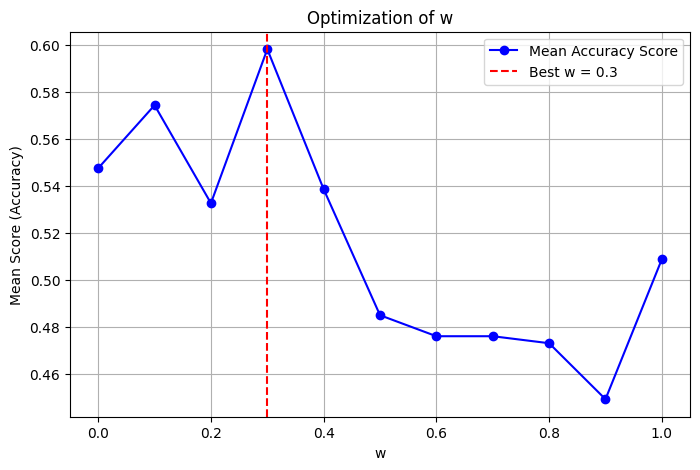

In [41]:
best_score = -np.inf
best_w = 1.0

w_values = []
mean_scores = []

for w in tqdm(np.arange(0, 1.1, 0.1), desc="Optimizing w"):
    fold_scores = []
    
    kf = StratifiedShuffleSplit(n_splits=3, test_size=0.3)
    splits = kf.split(X_labeled, y_labeled)

    for train_idx, val_idx in splits:
        X_train, X_val = X_labeled[train_idx], X_labeled[val_idx]
        y_train, y_val = y_labeled[train_idx], y_labeled[val_idx]

        # Add unlabeled data with nan labels
        X_train_full = np.vstack((X_train, unlabeled_images_features))
        y_train_full = np.concatenate([y_train, np.full(unlabeled_images_features.shape[0], np.nan)])

        # Build tree with current w
        tree = build_pct(X_train_full, y_train_full, max_depth=5, w=w)

        # Validate on labeled validation set
        y_pred = predict_pct(tree, X_val)
        # Use accuracy as the metric for multi-class classification
        score = accuracy_score(y_val, y_pred)
        fold_scores.append(score)

    mean_score = np.mean(fold_scores)
    w_values.append(w)
    mean_scores.append(mean_score)

    if mean_score > best_score:
        best_score = mean_score
        best_w = w

print(f"Optimal w: {best_w:.1f}")

plt.figure(figsize=(8, 5))
plt.plot(w_values, mean_scores, marker='o', linestyle='-', color='b', label='Mean Accuracy Score')
plt.axvline(best_w, color='r', linestyle='--', label=f'Best w = {best_w:.1f}')
plt.xlabel('w')
plt.ylabel('Mean Score (Accuracy)')
plt.title('Optimization of w')
plt.legend()
plt.grid(True)
plt.show()

best_w=0.4  # Or use the value determined from the optimization

In [42]:
ssl_forest = build_pct_forest(
    X_combined, 
    y_combined, 
    n_estimators=10,  # Increased for better performance in MCC
    max_depth=10, 
    w=best_w
)
ssl_forest = post_process_forest(ssl_forest, labeled_images_features, labeled_images_labels)

Building PCT Forest: 100%|██████████| 10/10 [05:16<00:00, 31.67s/it]


In [54]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
from sklearn.preprocessing import label_binarize

one_hot_preds, class_preds = predict_pct_forest(ssl_forest, test_images_features, num_classes)

# If test_labels was one-hot, it’s now class indices
if test_labels.ndim == 2 and test_labels.shape[1] > 1:
    test_labels = np.argmax(test_labels, axis=1)

# Binarize labels for AUPRC
test_labels_one_hot = label_binarize(test_labels, classes=np.arange(num_classes))

# Calculate metrics
accuracy = accuracy_score(test_labels, class_preds)
f1_macro = f1_score(test_labels, class_preds, average='macro')
f1_weighted = f1_score(test_labels, class_preds, average='weighted')

# Calculate AUPRC
auprc_macro = average_precision_score(test_labels_one_hot, one_hot_preds, average='macro')
auprc_weighted = average_precision_score(test_labels_one_hot, one_hot_preds, average='weighted')
auprc_micro = average_precision_score(test_labels_one_hot, one_hot_preds, average='micro')

# Print results
print("\nFinal Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_macro:.4f}")
print(f"AUPRC: {auprc_micro:.4f}")



Final Results:
Accuracy: 0.7070
F1 Score: 0.7117
AUPRC: 0.5093
